## Rigid Body Simulation

I'll admit, I kind of let this one get away from me, and I overbuilt it substantially.  I've been waiting a long time for an excuse to build an adaptive step size integrator with stopping conditions built in, so this is just the right occasion.  I am not going to use the $dt=0.001$ condition, I'm going to be bounding the estimated error per step to be no greater than $1 \times 10^{-9}$.

The integrator is a dormand-prince integrator with an adaptive step size.  The adaptive step size works on the general principle that with an nth order method, a decrease in step size will produce the following decrease in error:

\begin{align}
\frac{E_\text{new}}{E_\text{old}} & = \left( \frac{dx_\text{new}}{dx_\text{old}} \right)^n
\end{align}

Based on this principle, if we have a desired amount of error for each step, and using our step method, we get an estimate for the error we incurred, we can find an "ideal step size" that would have gotten exactly the amount of error that we want:


\begin{align}
\frac{dx_\text{ideal}}{dx_\text{old}} & = \left( \frac{E_\text{ideal}}{E_\text{old}} \right)^\frac{1}{n}
\end{align}

Thus, if our step incurs too little error, we take our integration to be overly cautious, and for the next step, we increase our step to the ideal step size we found.  If, however, our step incurs too much error, we reject that step and make a new step with the ideal step size which we calculated.

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [9]:
def dormand_prince_iteration(f, y0, t, dt, args=()):
    """ f(y,t) gives the derivative of y at t
        Given y(t), this function gets a 5th order
            approximation to y(t + dt).
        It also gives a 6th order error estimate.
        Coefficients from wikipedia."""
    k1 = f(y0,t, *args)
    k2 = f(y0+dt*(k1/5), t+0.2*dt, *args)
    k3 = f(y0+dt*(3*k1/40 + 9*k2/40), t+0.3*dt, *args)
    k4 = f(y0+dt*(44*k1/45 - 56*k2/15 + 32*k3/9 ), t+0.8*dt, *args)
    k5 = f(y0+dt*(19372*k1/6561 - 25360*k2/2187 + 64448*k3/6561 - 212*k4/729), t+8*dt/9, *args)
    k6 = f(y0+dt*(9017*k1/3168 - 355*k2/33 + 46732*k3/5247 + 49*k4/176 - 5103*k5/18656),t+dt, *args)
    k7 = f(y0+dt*(35*k1/384 + 500*k3/1113 + 125*k4/192 - 2187*k5/6784 + 11*k6/84), t+dt, *args)
    yf = dt*(35*k1/384 + 500*k3/1113 + 125*k4/192 - 2187*k5/6784 + 11*k6/84)
    other_est = dt*(5179*k1/57600 + 7571*k3/16695 + 393*k4/640 - 92097*k5/339200 + 187*k6/2100 + k7/40)
    return yf, (yf - other_est)

In [181]:
def minimize(f, t0, tf, f0, ff, tol):
    """ Given a function which is of one sign at the beginning
        of an interval, and the opposite sign at the end,
        this function uses linear approximations to refine
        the zero estimate."""
    tmid = (t0*ff - tf*f0)/(ff-f0)
    fmid = f(tmid)
    while np.abs(fmid) > tol:
        if fmid >= tol:
            t0 = tmid
            f0 = fmid
        elif fmid <= tol:
            tf = tmid
            ff = fmid
        tmid = (t0*ff - tf*f0)/(ff-f0)
        fmid = f(tmid)
        
    return tmid

In [262]:
def integrator(f, y0, tf, 
               args=(),
               stepsize=None,
               stopfunc=None,
               stopargs=(),
               step_error_tolerance=1e-8,
               stop_error_tolerance=1e-8,
               iteration=dormand_prince_iteration,
               method_order=5, maxits=1000, 
               output=False, return_error=False):
    """This function integrates a function from 0 to tf.
    This integration uses an adaptive step size,
    and tries to bound the error incurred per step.
    The function uses as a default a 5th order
    dormand prince iteration.
    
    The integration can be stopped with a stopfunc(),
    which should be positive when the integration should
    continue and zero at the point where you want it to stop."""
    
    if stepsize == None:
        stepsize=tf/100
        
    exponent = 1.0/method_order
    y = [y0]
    t = [0.0]
    nit = 0
    
    if return_error:
        errors = [0.0]
        
    while (t[-1] < tf) and (nit < maxits):
        nit += 1
        if output:
            print("Time: {0}".format(t[-1]))
        if t[-1] + stepsize > tf:
            stepsize = tf - t[-1]

        l_inf_err = float('inf')
        new_stepsize = stepsize
        while (l_inf_err >= step_error_tolerance) and (nit < maxits):
            nit += 1
            delta_yf, err = iteration(f, y[-1], t[-1], new_stepsize, args=args)
            stepsize = new_stepsize
            # we can use the scaling law to get the "ideal" error step
            l_inf_err = np.max(np.abs(err))
            if output:
                print("Got {} error with {} stepsize".format(l_inf_err, new_stepsize))
            new_stepsize = new_stepsize*((0.8*step_error_tolerance)/l_inf_err)**exponent
        
        # we know that stopfunc(x_{i-1}) > 0, so,
        #     if stopfunc(x_i) < 0, we can try to get a
        #     zero here.
        # we also know that an integration of the current
        #     stepsize achieves the error tolerances,
        #     so we don't have to worry about error tolerances
        if stopfunc:
            fa = stopfunc(y[-1], t[-1], *stopargs)
            fb = stopfunc(y[-1] + delta_yf, t[-1] + stepsize, *stopargs)
            if fb < 0:
                
                def minimizer(dt):
                    delta_yf, _ = iteration(f, y[-1], t[-1], dt, args=args)
                    return stopfunc(y[-1] + delta_yf, t[-1] + dt, *stopargs)
                
                stepsize = minimize(minimizer, 0, stepsize, 
                                    fa, fb, stop_error_tolerance)
                
                delta_yf, _ = iteration(f, y[-1], t[-1], stepsize, args=args)
                y.append(y[-1] + delta_yf)
                t.append(t[-1]+stepsize)
                if return_error:
                    errors.append(l_inf_err)
                break
     
        y.append(y[-1] + delta_yf)
        t.append(t[-1]+stepsize)
        if return_error:
            errors.append(l_inf_err)
        stepsize=new_stepsize
        
    Y = np.array(y)
    T = np.array(t)
    if return_error:
        return Y, T, np.array(errors)
    else:
        return Y, T

In [182]:
def w_body_frame(w, t, I1, I2, I3):
    """The derivative of w in the body frame"""
    return np.array([(I2-I3)/I1*w[1]*w[2],
                     (I3-I1)/I2*w[2]*w[0],
                     (I1-I2)/I3*w[0]*w[1]])

In [159]:
def stopfunc(w, t, winit, tmin, wprime_init, weps):
    """If t > 1.0, and w and winit are close to each other,
    then keep track of the projection of the difference
    between w and winit onto the initial derivative.
    This will be positive when the angular momentum is
    "behind" the initial point and negative when it is 
    in front, satisfying the stopping function
    condition."""
    if (t > tmin) and np.linalg.norm(w-winit) < weps:
        return np.dot(wprime_init, winit-w)
    else:
        return 10.0

## Performing the Integration

Below we see the integration performed.
The initial angular momentum is $\omega_1 = 1$, $\omega_2 = 1$, $\omega_3 = 0.9$.
The principal axes of angular momentum is $I_{11} = 1$, $I_{22} = 2$, $I_{33} = 3$.
We also show the point at which integration stopped.

We set our tolerance to be to the 9th decimal place so that we can get 8 significant digits.

In [263]:
w0 = np.array([1.0, 1.0, 0.9])
I1, I2, I3 = 1,2,3
Y, T, errors = integrator(w_body_frame, 
           w0, 
           7.5,
           args=(I1, I2, I3),
           step_error_tolerance=1e-9,
           stopfunc=stopfunc,
           stop_error_tolerance=1e-9,
           stopargs=(w0, 1.0, w_body_frame(w0, 0, I1, I2, I3), 1.0),
           return_error=True)

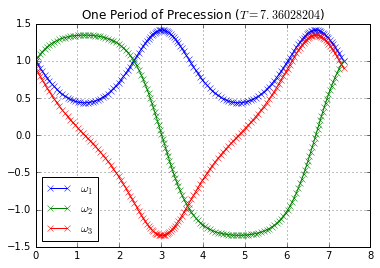

In [271]:
plt.figure(dpi=600)
plt.plot(T, Y[:,0], marker='x', label=r"$\omega_1$")
plt.plot(T, Y[:,1], marker='x', label=r"$\omega_2$")
plt.plot(T, Y[:,2], marker='x', label=r"$\omega_3$")
plt.legend(loc="lower left")
plt.grid(True)
plt.title(r"One Period of Precession ($T={:1.8f}$)".format(T[-1]))

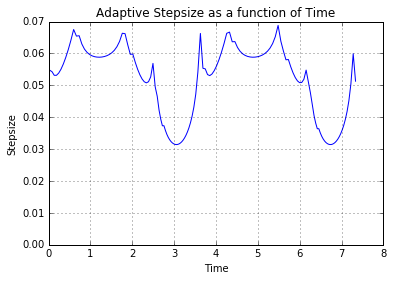

In [272]:
plt.plot((T[:-1] + T[1:])/2.0, T[1:] - T[:-1])
plt.axis([0, 8, 0, 0.07])
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Stepsize")
plt.title("Adaptive Stepsize as a function of Time")

### Period

In [194]:
# the final period
print("T = {:1.8f}".format(T[-1]))

T = 7.36028204


Now, to get the basis vectors as a function of time, we note that $\dot{\hat{i}} = \omega_\text{LAB} \times \hat{i}$.  Since $\omega_\text{LAB} = \omega_1 \hat{1} + \omega_2 \hat{2} + \omega_3 \hat{3}$,

\begin{align}
\dot{\hat{1}} & = - \omega_2 \hat{3} + \omega_3 \hat{2} \\
\dot{\hat{2}} & = - \omega_3 \hat{1} + \omega_1 \hat{3} \\
\dot{\hat{3}} & = - \omega_1 \hat{2} + \omega_2 \hat{1} 
\end{align}

We can interpolate the $\omega$'s from our previous solution, and integrate.

In [202]:
w1 = interp1d(T, Y[:,0], kind="cubic")
w2 = interp1d(T, Y[:,1], kind="cubic")
w3 = interp1d(T, Y[:,2], kind="cubic")

In [212]:
def basis_vector_derivs(y,t, w1, w2, w3):
    pa1 = y[:3]
    pa2 = y[3:6]
    pa3 = y[6:]
    
    pa1dot = w3(t)*pa2 - w2(t)*pa3
    pa2dot = w1(t)*pa3 - w3(t)*pa1
    pa3dot = w2(t)*pa1 - w1(t)*pa2
    
    return np.append(pa1dot, 
                      np.append(pa2dot, pa3dot))

In [217]:
BasisVectors, Tvecs = integrator(basis_vector_derivs,
                                 np.append([1.0,0,0],
                                    np.append([0,1.0,0],
                                            [0,0,1.0])),
                                 T[-1],
                                 args=(w1, w2, w3))

In [221]:
U = np.reshape(BasisVectors[-1,:], (3,3))

In [224]:
U

array([[-0.88816083, -0.30741115,  0.34156794],
       [ 0.30741108,  0.15502213,  0.93886449],
       [-0.34156801,  0.93886446, -0.04318296]])

### Basis Vectors

In [238]:
print("1 = {}".format(U[0,:]))
print("2 = {}".format(U[1,:]))
print("3 = {}".format(U[2,:]))

1 = [-0.88816083 -0.30741115  0.34156794]
2 = [ 0.30741108  0.15502213  0.93886449]
3 = [-0.34156801  0.93886446 -0.04318296]


We can see that our errors for $U$ are on the order of $1e-9$

In [223]:
np.dot(U,U.T)

array([[  9.99999929e-01,   7.89619398e-09,   7.99166903e-09],
       [  7.89619398e-09,   9.99999964e-01,   3.26555834e-08],
       [  7.99166903e-09,   3.26555834e-08,   9.99999958e-01]])

### Rotation Angle after 1 period

Note that $\text{Tr} U = 1 + 2 \cos \theta$, such that:

\begin{align}
\cos \theta & = \frac{1 - \text{Tr} U}{2}
\end{align}

In [239]:
theta = (1-np.trace(U))/2.0
print("The object rotates {:2.6f} degrees".format(180*theta/np.pi))

The object rotates 50.887867 degrees
